# Analysis and generation of experience data collected from the simulation

## 1. Import and filter data


before: 
(2900, 40)
after: 
(2582, 42)


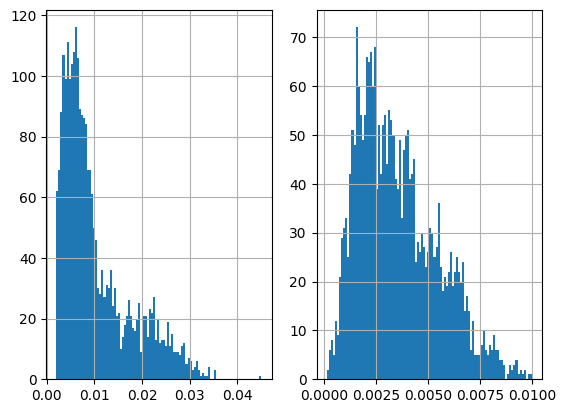

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./data/exp.csv', header=None)

# print shape of the dataframe
print("before: ")
print(df.shape)

# information of the dataframe
# 0-11: obs
# 12-14: achieved_goal
# 15-17: desired_goal
# 18-20: action
# 21: reward
# 22-33: next_obs
# 34-36: next_achieved_goal
# 37-39: next_desired_goal

# make last column to be the distance between obs and next_obs
df[40] = ((df[0] - df[22])**2 + (df[1] - df[23])**2 + (df[2] - df[24])**2)**0.5

# make last column to be the distance between desired_goal and next_desired_goal
df[41] = ((df[15] - df[37])**2 + (df[16] - df[38])**2 + (df[17] - df[39])**2)**0.5

# remove rows that has distance < 0.01
df = df[df[40] > 0.002]
df = df[df[41] < 0.035]

# remove rows that has distance > 0.1
df = df[df[41] < 0.01]

fig, ax = plt.subplots(1, 2)

# plot the distribution of column 37
df[40].hist(bins=100, ax=ax[0])

# plot the distribution of column 38
df[41].hist(bins=100, ax=ax[1])

print("after: ")
print(df.shape)

## 2. Train a linear question model in order to predict the next gripper position based on the selected action and the original gripper position

0.9809674273525425


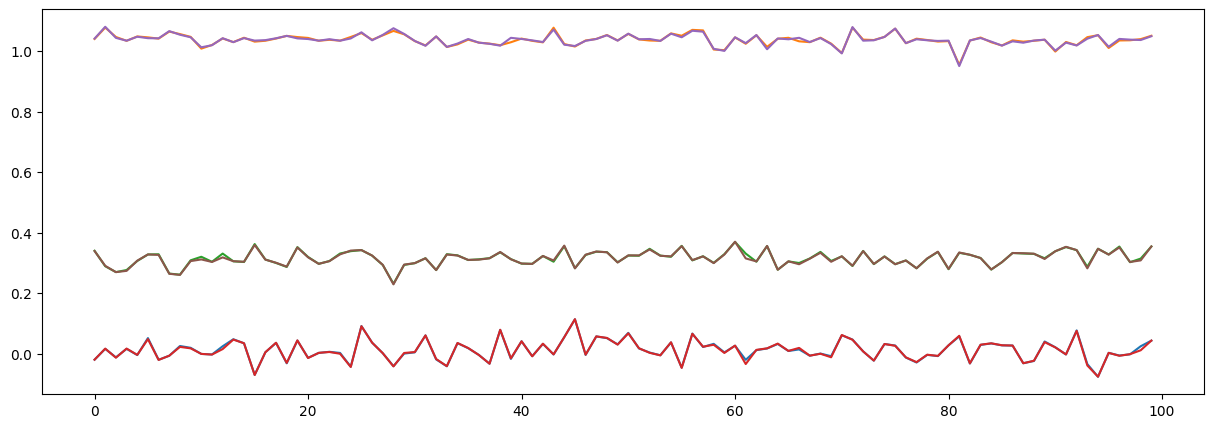

In [2]:
grip_pos = df[[0, 1, 2]]
grip_pos_next = df[[22, 23, 24]].rename(columns={22: 0, 23: 1, 24: 2})
action = df[[18, 19, 20]].rename(columns={18: 3, 19: 4, 20: 5})

# seperate the data into training and testing
from sklearn.model_selection import train_test_split
grip_pos_train, grip_pos_test, grip_pos_next_train, grip_pos_next_test, action_train, action_test = train_test_split(grip_pos, grip_pos_next, action, test_size=0.2, random_state=42)

# # use linear regression to predict the next grip position
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(grip_pos_train.join(action_train), grip_pos_next_train)

# print the score
print(reg1.score(grip_pos_test.join(action_test), grip_pos_next_test))

pred = reg1.predict(grip_pos_test.join(action_test))
actual = grip_pos_next_test

# reset index of actual to 0 to len(actual)
actual = actual.reset_index(drop=True)

# plot the results
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(actual[:100], label='actual')
plt.plot(pred[:100], label='pred')

## 3. Train a linear regression model in order to predict the next target position based on the target relative position and the target original position

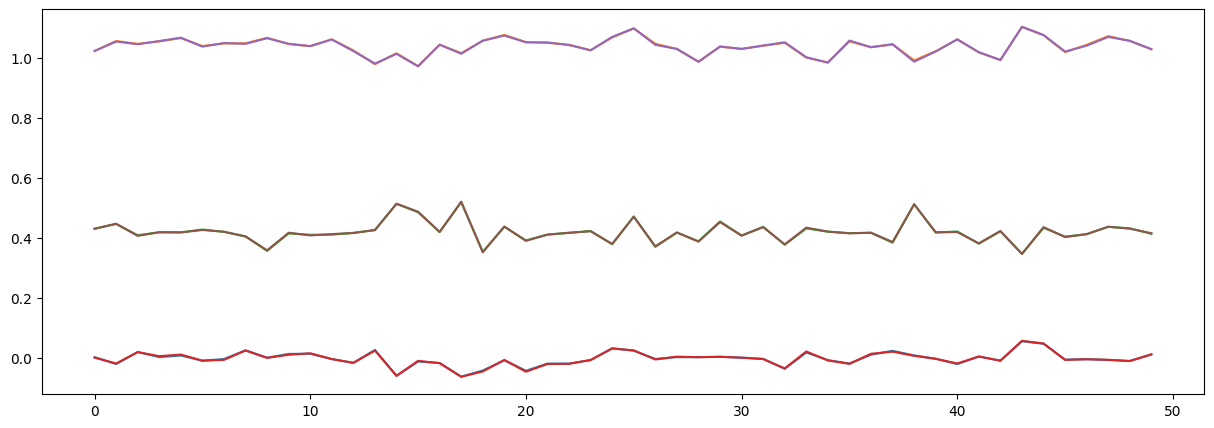

In [3]:
target_pos = df[[3, 4, 5]].rename(columns={3: 0, 4: 1, 5: 2})
target_pos_next = df[[25, 26, 27]].rename(columns={25: 0, 26: 1, 27: 2})
target_rel_vel = df[[9, 10, 11]].rename(columns={9: 3, 10: 4, 11: 5})

# seperate the data into training and testing
target_pos_train, target_pos_test, target_pos_next_train, target_pos_next_test, target_rel_vel_train, target_rel_vel_test = train_test_split(target_pos, target_pos_next, target_rel_vel, test_size=0.2, random_state=42)

# use linear regression to predict the next position of the target from the current position and relative velocity
reg2 = LinearRegression().fit(target_pos_train.join(target_rel_vel_train), target_pos_next_train)

# predict the next position of the target from the current position and relative velocity
target_pos_next_pred = reg2.predict(target_pos_test.join(target_rel_vel_test))
pred = target_pos_next_pred
actual = target_pos_next_test
actual = actual.reset_index(drop=True)

# plot the result
plt.figure(figsize=(15, 5))
plt.plot(actual[:50], label='actual')
plt.plot(pred[:50], label='pred')



## 4. Generate more data for the gripper position

grip_pos_min:  0   -0.077791
1    0.953013
2    0.214981
dtype: float64
grip_pos_max:  0    0.140829
1    1.111930
2    0.380054
dtype: float64
action_min:  [-0.99903709 -0.99991965 -0.99711359]
action_max:  [0.99785066 0.99970973 0.99946314]


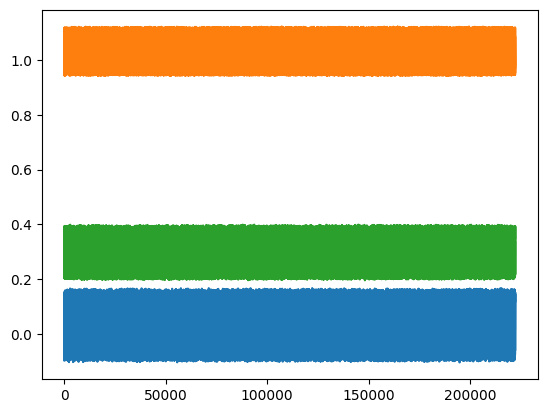

In [4]:
# get min max of grip_pos
grip_pos_min = grip_pos.min()
grip_pos_max = grip_pos.max()
action_min = action.min()
action_max = action.max()

# reshape action_min from (3, 1) to (3, )
action_min = action_min.values.reshape(3, )
action_max = action_max.values.reshape(3, )

print("grip_pos_min: ", grip_pos_min)
print("grip_pos_max: ", grip_pos_max)
print("action_min: ", action_min)
print("action_max: ", action_max)

import numpy as np

# generate random grip_pos 
grip_pos_random = np.random.uniform(grip_pos_min, grip_pos_max, size=(222222, 3))
grip_pos_random = pd.DataFrame(grip_pos_random)

# generate random action
action_random = np.random.uniform(action_min, action_max, size=(222222, 3))
action_random = pd.DataFrame(action_random).rename(columns={0: 3, 1: 4, 2: 5})

# predict the next grip_pos
grip_pos_next = reg1.predict(grip_pos_random.join(action_random))

# plot grip_pos_next
fig = plt.figure()
plt.plot(grip_pos_next, label='grip_pos_next')


## 5. Generate more data for the target position

target_pos_min:  0   -0.103437
1    0.921058
2    0.309763
dtype: float64
target_pos_max:  0    0.121503
1    1.158710
2    0.523944
dtype: float64
target_rel_vel_min:  3   -0.256914
4   -0.599258
5   -0.176732
dtype: float64
target_rel_vel_max:  3    0.271074
4    0.390669
5    0.333755
dtype: float64


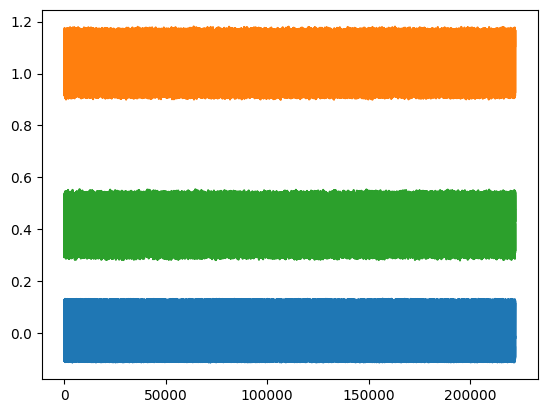

In [5]:
target_pos_min = target_pos.min()
target_pos_max = target_pos.max()
target_rel_vel_min = target_rel_vel.min()
target_rel_vel_max = target_rel_vel.max()

print("target_pos_min: ", target_pos_min)
print("target_pos_max: ", target_pos_max)
print("target_rel_vel_min: ", target_rel_vel_min)
print("target_rel_vel_max: ", target_rel_vel_max)

# generate random target_pos
target_pos_random = np.random.uniform(target_pos_min, target_pos_max, (222222, 3))
target_pos_random = pd.DataFrame(target_pos_random)

# generate random target_rel_vel
target_rel_vel_random = np.random.uniform(target_rel_vel_min, target_rel_vel_max, (222222, 3))
target_rel_vel_random = pd.DataFrame(target_rel_vel_random).rename(columns={0: 3, 1: 4, 2: 5})

# predict the next target_pos
target_pos_next_pred = reg2.predict(target_pos_random.join(target_rel_vel_random))
pred = target_pos_next_pred

# plot the prediction
fig = plt.figure()
plt.plot(pred, label='target_pos_next_pred')


## 6. Combine the generated features to make a new dataset

In [6]:
grip_pos_random = grip_pos_random.rename(columns={0: 0, 1: 1, 2: 2}).reset_index(drop=True)
target_pos_random = target_pos_random.rename(columns={0: 3, 1: 4, 2: 5}).reset_index(drop=True)
delta_pos = target_pos_random.rename(columns={3: 0, 4: 1, 5: 2}) - grip_pos_random
delta_pos = delta_pos.rename(columns={0: 6, 1: 7, 2: 8}).reset_index(drop=True)
target_rel_vel_random = target_rel_vel_random.rename(columns={3: 9, 4: 10, 5: 11}).reset_index(drop=True)
achieved_goal = grip_pos_random.rename(columns={0: 12, 1: 13, 2: 14})
goal = target_pos_random.rename(columns={3: 15, 4: 16, 5: 17})
action = action_random.rename(columns={3: 18, 4: 19, 5: 20})
grip_pos_next = pd.DataFrame(grip_pos_next).rename(columns={0: 22, 1: 23, 2: 24}).reset_index(drop=True)
target_pos_random_next = pd.DataFrame(target_pos_next_pred).rename(columns={0: 25, 1: 26, 2: 27}).reset_index(drop=True)
delta_pos_next = target_pos_random_next.rename(columns={25: 0, 26: 1, 27: 2}) - grip_pos_next.rename(columns={22: 0, 23: 1, 24: 2})
delta_pos_next = delta_pos_next.rename(columns={0: 28, 1: 29, 2: 30}).reset_index(drop=True)
target_rel_vel_random_next = target_rel_vel_random.rename(columns={3: 31, 4: 32, 5: 33}).reset_index(drop=True)
achieved_goal_next = grip_pos_next.rename(columns={22: 34, 23: 35, 24: 36})
REWARD_SCALE=10.0
reward = pd.DataFrame(-np.linalg.norm(delta_pos_next.to_numpy(), axis=-1)/REWARD_SCALE).rename(columns={0: 21})

# concat all the data
new_data = pd.concat([grip_pos_random, target_pos_random, delta_pos, target_rel_vel_random, achieved_goal, goal, action, reward, grip_pos_next, target_pos_random_next, delta_pos_next, target_rel_vel_random_next, achieved_goal_next, target_pos_random_next], axis=1)
new_data = new_data.reset_index(drop=True).to_numpy()

# remove original calculated distance
old_data = df.reset_index(drop=True).to_numpy()
old_data = np.delete(old_data, [40, 41], axis=1)
# concat new data and old data
new_data = np.concatenate((old_data, new_data), axis=0)
# export to csv
np.savetxt("./data/gen_data.csv", new_data, delimiter=",")

## 7. Train the original model with the new dataset

First, specify the path to the model file, and select if HER sampler is used or not.

In [7]:
model_path = 'saved_models/UnderwaterEnv/model_default_epoch1_2023-08-28-07-33-54.pt'
her_used = False

Define neccessary functions for the training

In [8]:
from torch.utils.tensorboard import SummaryWriter
from mpi_utils.normalizer import normalizer
import torch
from rl_modules.models import actor, critic
from mpi_utils.mpi_utils import sync_networks, sync_grads
from her_modules.her import her_sampler
from rl_modules.replay_buffer import replay_buffer

REWARD_SCALE = 10.0

def _goal_distance(goal_a, goal_b):
    assert goal_a.shape == goal_b.shape
    return np.linalg.norm(goal_a - goal_b, axis=-1)

def compute_reward(achieved_goal, desired_goal, info=None, reward_type="dense", max_reward=1.0):
    distance = _goal_distance(achieved_goal, desired_goal)
    reward = -distance.astype(np.float32)/REWARD_SCALE
    return reward
    
def _preproc_og(o, g):
    o = np.clip(o, -200, 200)
    g = np.clip(g, -200, 200)
    return o, g
    
def _update_network(transitions, 
                    o_norm_, 
                    g_norm_, 
                    actor_optim, 
                    critic_optim, 
                    actor_network, 
                    critic_network, 
                    i,
                    cuda=False):
    # pre-process the observation and goal
    o, o_next, g, g_next = transitions['obs'], transitions['obs_next'], transitions['g'], transitions['g_next']
    transitions['obs'], transitions['g'] = _preproc_og(o, g)
    transitions['obs_next'], transitions['g_next'] = _preproc_og(o_next, g_next)

    # start to do the update
    obs_norm = o_norm_.normalize(transitions['obs'])
    g_norm = g_norm_.normalize(transitions['g'])
    inputs_norm = np.concatenate([obs_norm, g_norm], axis=1)
    obs_next_norm = o_norm_.normalize(transitions['obs_next'])
    g_next_norm = g_norm_.normalize(transitions['g_next'])
    inputs_next_norm = np.concatenate([obs_next_norm, g_next_norm], axis=1)

    if i%20 == 0:
        print('---> with i = ', i)
        print('-> before normalization')
        print('obs: ', o[:4])
        print('g: ', g[:4])
        print('obs_next: ', o_next[:4])
        print('g_next: ', g_next[:4])
        print('-> after normalization')
        print('obs_norm: ', obs_norm[:4])
        print('g_norm: ', g_norm[:4])
        print('obs_next_norm: ', obs_next_norm[:4])
        print('g_next_norm: ', g_next_norm[:4])

    # transfer them into the tensor
    inputs_norm_tensor = torch.tensor(inputs_norm, dtype=torch.float32)
    inputs_next_norm_tensor = torch.tensor(inputs_next_norm, dtype=torch.float32)
    actions_tensor = torch.tensor(transitions['actions'], dtype=torch.float32)
    r_tensor = torch.tensor(transitions['r'], dtype=torch.float32) 

    if cuda:
        inputs_norm_tensor = inputs_norm_tensor.cuda()
        inputs_next_norm_tensor = inputs_next_norm_tensor.cuda()
        actions_tensor = actions_tensor.cuda()
        r_tensor = r_tensor.cuda()

    # calculate the target Q value function
    with torch.no_grad():
        gamma = 0.98
        target_q_value = r_tensor
        target_q_value = target_q_value.detach()

        # clip the q value
        clip_return = 1 / (1 - gamma)
        target_q_value = torch.clamp(target_q_value, -clip_return, 0)

    # the q loss
    real_q_value = critic_network(inputs_norm_tensor, actions_tensor)
    critic_loss = (target_q_value - real_q_value).pow(2).mean()

    if i%20 == 0:
        print('target_q_value  (r_tensor): ', r_tensor[:4], ', real_q_value: ', real_q_value[:4])

    # the actor loss
    actions_real = actor_network(inputs_norm_tensor)
    actor_loss = -critic_network(inputs_norm_tensor, actions_real).mean()

    if i%20 == 0:
        print('actions_real: ', actions_real[:4])

    # start to update the network
    actor_optim.zero_grad()
    actor_loss.backward()
    sync_grads(actor_network)
    actor_optim.step()

    # update the critic_network
    critic_optim.zero_grad()
    critic_loss.backward()
    sync_grads(critic_network)
    critic_optim.step()

    # print('actor_loss: ', actor_loss.item(), 'critic_loss: ', critic_loss.item(), end='\r')
    return actor_loss.item(), critic_loss.item()

# update the normalizer
def _update_normalizer(transitions, o_norm, g_norm):
    mb_obs, mb_ag, mb_g, mb_actions, mb_rewards, mb_obs_next, mb_ag_next, mb_g_next = transitions

    # create the new buffer to store them
    transitions = {'obs': mb_obs, 
                    'ag': mb_ag,
                    'g': mb_g, 
                    'actions': mb_actions, 
                    'obs_next': mb_obs_next,
                    'ag_next': mb_ag_next,
                    'g_next': mb_g_next,
                    'r': mb_rewards
                    }
    
    obs, g = transitions['obs'], transitions['g']
    obs_next, g_next = transitions['obs_next'], transitions['g_next']

    # pre process the obs and g
    transitions['obs'], transitions['g'] = _preproc_og(obs, g)

    # pre process the obs_next and g_next
    transitions['obs_next'], transitions['g_next'] = _preproc_og(obs_next, g_next)

    # update
    o_norm.update(transitions['obs'])
    g_norm.update(transitions['g'])
    o_norm.update(transitions['obs_next'])
    g_norm.update(transitions['g_next'])

    # recompute the stats
    o_norm.recompute_stats()
    g_norm.recompute_stats()

def _soft_update_target_network(target, source, polyak):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_((1 - polyak) * param.data + polyak * target_param.data)

def sample_her_transitions(transitions, replay_k):
    future_p = 1 - (1. / (1 + replay_k))
    rollout_batch_size = transitions['actions'].shape[0]

    # her idx
    her_indexes = np.where(np.random.uniform(size=rollout_batch_size) < future_p)

    # replace goal with achieved goal
    future_ag = transitions['ag'][her_indexes]
    transitions['g'][her_indexes] = future_ag
    transitions['g_next'][her_indexes] = future_ag

    # to get the params to re-compute reward
    transitions['r'] = np.expand_dims(compute_reward(transitions['ag_next'], transitions['g_next'], None), 1)
    transitions = {k: transitions[k].reshape(rollout_batch_size, *transitions[k].shape[1:]) for k in transitions.keys()}

    return transitions
    

/home/khiem/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Start the training

In [9]:
# nessary params for the training
env_params = {
    'obs': 12, # size of observation
    'goal': 3, # size of goal
    'action': 3, # size of action
    'action_max': 1, # max value of action
    'max_timesteps': 25 # max value of timesteps in one episode
}
learning_rate = 0.001
n_batches = 10000
replay_k = 2 # if the HER sampler is used
cuda = True
polyak = 0.0001 # since the generated data is much more than the original data, so we use a small polyak to overfit the data

# create the normalizer
o_norm = normalizer(size=env_params['obs'], default_clip_range=5)
g_norm = normalizer(size=env_params['goal'], default_clip_range=5)

# create the network
actor_network = actor(env_params)
critic_network = critic(env_params)

# load the model
o_mean, o_std, g_mean, g_std, actor_model, critic_model = torch.load(model_path, map_location=lambda storage, loc: storage)
o_norm.mean = o_mean
o_norm.std = o_std
g_norm.mean = g_mean
g_norm.std = g_std
actor_network.load_state_dict(actor_model)
critic_network.load_state_dict(critic_model)

# sync the network
sync_networks(actor_network)
sync_networks(critic_network)

# build up the target network
actor_target_network = actor(env_params)
critic_target_network = critic(env_params)

# if use gpu
actor_network.cuda()
critic_network.cuda()
actor_target_network.cuda()
critic_target_network.cuda()

# load the weights into the target networks
actor_target_network.load_state_dict(actor_network.state_dict())
critic_target_network.load_state_dict(critic_network.state_dict())

actor_optim = torch.optim.Adam(actor_network.parameters(), lr=learning_rate)
critic_optim = torch.optim.Adam(critic_network.parameters(), lr=learning_rate)

# obs, ag, g, actions, rewards, obs_next, ag_next
transitions = [new_data[:, 0:12], 
               new_data[:, 12:15], 
               new_data[:, 15:18], 
               new_data[:, 18:21], 
               new_data[:, 21:22], 
               new_data[:, 22:34], 
               new_data[:, 34:37],
               new_data[:, 37:40]]

# update the normalizer
_update_normalizer(transitions, o_norm, g_norm)

mb_obs, mb_ag, mb_g, mb_actions, mb_rewards, mb_obs_next, mb_ag_next, mb_g_next = transitions
transitions = {'obs': mb_obs, 
                'ag': mb_ag,
                'g': mb_g, 
                'actions': mb_actions, 
                'obs_next': mb_obs_next,
                'ag_next': mb_ag_next,
                'g_next': mb_g_next,
                'r': mb_rewards
                }

# her sampler
if her_used:
    transitions = sample_her_transitions(transitions, replay_k)

writer = SummaryWriter()
for i in range(n_batches):
    actor_loss, critic_loss = _update_network(transitions, 
                                              o_norm, 
                                              g_norm, 
                                              actor_optim, 
                                              critic_optim, 
                                              actor_network, 
                                              critic_network, 
                                              i,
                                              cuda=cuda)
    writer.add_scalar('actor_loss', actor_loss, i)
    writer.add_scalar('critic_loss', critic_loss, i)
    _soft_update_target_network(actor_target_network, actor_network, polyak)
    _soft_update_target_network(critic_target_network, critic_network, polyak)
    print('batch: ', i, ' actor_loss: ', actor_loss, ' critic_loss: ', critic_loss, end='\r')

---> with i =  0
-> before normalization
obs:  [[ 1.01703592e-03  1.03745484e+00  3.07710469e-01 -8.33885558e-03
   1.06048715e+00  4.18932289e-01 -9.35589150e-03  2.30323076e-02
   1.11221820e-01 -5.65124617e-04 -7.29794102e-03  1.84494816e-02]
 [ 1.10017601e-02  1.03801036e+00  3.21996570e-01 -8.25731084e-03
   1.06157148e+00  4.18863267e-01 -1.92590710e-02  2.35611200e-02
   9.68666971e-02  1.25164762e-02 -2.61975825e-01  1.23956792e-01]
 [ 1.37105286e-02  1.03595662e+00  3.21138620e-01 -8.59069824e-03
   1.06182182e+00  4.19737667e-01 -2.23012269e-02  2.58651972e-02
   9.85990465e-02  4.08768188e-03 -3.73581760e-02  3.20120826e-02]
 [ 1.33119058e-02  1.03756595e+00  3.23172152e-01 -8.50971788e-03
   1.06172025e+00  4.19799358e-01 -2.18216237e-02  2.41543055e-02
   9.66272056e-02  6.85915002e-04 -1.09591903e-02  1.76857077e-02]]
g:  [[-0.00833886  1.06048715  0.41893229]
 [-0.00825731  1.06157148  0.41886327]
 [-0.0085907   1.06182182  0.41973767]
 [-0.00850972  1.06172025  0.419799

## 8. Save the trained model

In [ ]:
from datetime import datetime

date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
training_label = 'default'
model_path = 'saved_models/RefinedUnderwaterEnv'
torch.save([o_norm.mean, o_norm.std, g_norm.mean, g_norm.std, actor_network.state_dict(), critic_network.state_dict()], \
            model_path + f'/model_{training_label}_{date}.pt')